In [3]:
import SimpleITK as sitk
import numpy as np, torch, nrrd, pandas as pd
import monai.metrics as met

In [4]:
data = data = pd.read_csv('/Users/joemarsilla/Downloads/pred/data23_121321/dataset23.csv', index_col=0)

In [5]:
data.head()

,0,1
0,/cluster/projects/radiomics/dataset2_3/raw/052...,/cluster/projects/radiomics/dataset2_3/raw/052...
1,/cluster/projects/radiomics/dataset2_3/raw/052...,/cluster/projects/radiomics/dataset2_3/raw/052...
2,/cluster/projects/radiomics/dataset2_3/raw/052...,/cluster/projects/radiomics/dataset2_3/raw/052...
3,/cluster/projects/radiomics/dataset2_3/raw/052...,/cluster/projects/radiomics/dataset2_3/raw/052...
4,/cluster/projects/radiomics/dataset2_3/raw/052...,/cluster/projects/radiomics/dataset2_3/raw/052...


In [6]:
pats = list(data['0'])

In [7]:
p = [p.split('/')[-2].partition('.')[0] for p in pats]

In [8]:
# p = list(set(p))

In [9]:
from collections import OrderedDict
p = OrderedDict((x, True) for x in p).keys()

In [10]:
p = list(p)

In [11]:
p

['0522c0330',
 '0522c0806',
 '0522c0878',
 'HN-HGJ-052',
 'HN-CHUS-068',
 '0522c0427',
 'HN-CHUS-076',
 'HN-CHUS-033',
 'HN-HGJ-012',
 'HN-HGJ-036',
 '0522c0297',
 'HN-CHUS-100',
 'HN-HMR-016',
 'HN-HGJ-090',
 'HN-CHUS-060',
 'HN-HGJ-013',
 '0522c0159',
 '0522c0081',
 'HN-HGJ-084',
 '0522c0328',
 '0522c0773',
 '0522c0142',
 '0522c0519',
 '0522c0147',
 'HN-HMR-009',
 '0522c0667',
 '0522c0796',
 'HN-CHUS-039',
 'HN-HGJ-018',
 'HN-HMR-034',
 '0522c0661',
 '0522c0248',
 '0522c0003',
 'HN-HMR-030',
 '0522c0251',
 'HN-HGJ-024',
 '0522c0419',
 'HN-HGJ-060',
 'HN-CHUS-067',
 '0522c0768',
 'HN-HGJ-042',
 '0522c0693',
 '0522c0726',
 'HN-HGJ-022',
 'HN-HGJ-007',
 '0522c0727',
 'HN-HMR-027',
 '0522c0713',
 'HN-CHUS-084',
 '0522c0883',
 '0522c0072',
 'HN-HGJ-078',
 'HN-HGJ-088',
 'HN-HGJ-050',
 'HN-HGJ-067',
 'HN-HGJ-077',
 '0522c0457',
 '0522c0079',
 'HN-HMR-025',
 'HN-HMR-020',
 'HN-CHUS-056',
 'HN-HGJ-053',
 'HN-CHUS-054',
 'HN-HGJ-089',
 'HN-HMR-005',
 '0522c0070',
 'HN-HGJ-001',
 'HN-CHUS-043'

In [20]:
hn1_classes = ['Brain Stem', 'Spinal Cord', 'Larynx', 'Mandible', 'Parotid L', 'Parotid R', 'Ear-L', 'Ear-R', 'Lens L', "Lens-R", "Eye-L","Eye-R", 'Optic Nerve L', 'Optic Nerve R', 'Optical Chiasm', 'Brachial Plexus', 'Brachial Plexus']
# deep_classes2 = ['Brainstem','Lens_Lt', 'Lens_Rt', 'Mandible', 'Optic_Nerve_Lt', 'Optic_Nerve_Rt', 'Parotid_Lt', 'Parotid_Rt', 'Orbit_Lt', 'Orbit_Rt', 'Spinal_Cord', 'Spinal_Canal']
index_ = [0,1,3,4,5,6,7,8,11,12,13,14,15,16,17,9,10]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [14]:
index_.index(5)

4

In [13]:
len(index_)

15

In [15]:
len(hn1_classes)

15

In [16]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice


In [17]:
def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [18]:
import scipy.ndimage.measurements as me
def fix_outputs(out_):
    com=me.center_of_mass(out_)
    assert len(com)==3
    val = int(com[2])
    
    # Parotids...
    sl = out_[:,:,:val]
    sl[sl==6] = 7
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==7] = 6
    out_[:,:,val:]=sl

    # # Acoustics...
    sl = out_[:,:,:val]
    sl[sl==8] = 9
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==9] = 8
    out_[:,:,val:]=sl

    # Plexus
    sl = out_[:,:,:val]
    sl[sl==11] = 10
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==10] = 11
    out_[:,:,val:]=sl

    # Lens
    sl = out_[:,:,:val]
    sl[sl==12] = 13
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==13] = 12
    out_[:,:,val:]=sl

    # Eyes
    sl = out_[:,:,:val]
    sl[sl==14] = 15
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==15] = 14
    out_[:,:,val:]=sl

    # Eyes
    sl = out_[:,:,:val]
    sl[sl==14] = 15
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==15] = 14
    out_[:,:,val:]=sl

    # # Optic Nerves...
    sl = out_[:,:,:val]
    sl[sl==16] = 17
    out_[:,:,:val] = sl
    sl = out_[:,:,val:]
    sl[sl==17] = 16
    out_[:,:,val:]=sl
    
    return out_

In [19]:
oars = []
hn1_oars = []
dce =  []
hd =   []
sd =   []
p_ = []

In [34]:
import nrrd

In [38]:
# path of folders...
# observer = 'radiographer'
path = f'/Users/joemarsilla/Downloads/data/dataset2_3/raw/' 

for i, pat in enumerate(p):
    path_ = path+pat+'/structures/'
    # load subsequent patient outputs from model...
    out_path = f"/Users/joemarsilla/Downloads/pred/data23_121321/FINAL_/outs_{i}_FULL.nrrd"
    # outputs = torch.from_numpy(np.load(out_path))
    outputs = torch.from_numpy(nrrd.read(out_path)[0])
    # targets = torch.from_numpy(np.load(out_path.replace('outs', 'in')))
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    try:
        for k, val in enumerate(chosen):
            if k in index_:
                try:
                    val_ = hn1_classes[index_.index(k)]
                    if 'H' in pat:
                        targ = nrrd.read(path_+val_+'.nrrd')
                        targ = targ[0].transpose(2,0,1)
                    # using SIMPLEITK
                    else:
                        targ = sitk.ReadImage(path_+val_+'.nrrd')
                        targ = sitk.GetArrayFromImage(targ)
                    shape = targ.shape
                    # img = self.resample_sitk(img, new_spacing=np.array((1.0, 1.0, 2.0)))
                    # targ = resample_sitk(targ, mode="nearest", new_spacing=np.array((1.0, 1.0, 2.0)))
                    targ = torch.tensor(targ[shape[0]//8:shape[0]-shape[0]//8])
                    outs = outputs[0,k+1,shape[0]//8:shape[0]-shape[0]//8]
                    dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
                    h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
                    s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
                    print(val, dc, h)
                    # save metrics...
                    dce.append(dc[0][0].item())
                    hd.append(h[0][0].item())
                    sd.append(s[0][0].item())
                    # ob.append(observer)
                    # pddca_oars.append(pddca_classes[k])
                    oars.append(val)
                    hn1_oars.append(val_)
                    p_.append(pat)
                except Exception as e:
                    print(e)
                    print(f'No {val} in {pat}')
            else:
                print(f"No {val} in {pat}")
    except Exception as e:
        print(e)
        print(pat, ' is BAD.')

4 torch.Size([1, 181, 512, 512]) torch.Size([1, 181, 512, 512])
19
(1, 20, 181, 512, 512)
BSTEM tensor([[0.7395]]) tensor([[3.7417]], dtype=torch.float64)
Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/joemarsilla/Downloads/data/dataset2_3/raw/0522c0330/structures/Spinal Cord.nrrd" does not exist.
No SPCOR in 0522c0330
No ESOPH in 0522c0330
Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/joemarsilla/Downloads/data/dataset2_3/raw/0522c0330/structures/Larynx.nrrd" does not exist.
No LARYNX in 0522c0330
Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/joemarsilla/Downloads/data/dataset2_3/raw/0522c0330/structures/Mandible.nrrd" does not exist.
No MAND in 0522c0330
LPAR tensor([[0.8489]

/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/surface_distance.py:155: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


BSTEM tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
SPCOR tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
No ESOPH in HN-HGJ-052
LARYNX tensor([[0.1203]]) tensor([[67.1279]], dtype=torch.float64)
MAND tensor([[0.5081]]) tensor([[116.0978]], dtype=torch.float64)
LPAR tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
RPAR tensor([[0.0012]]) tensor([[30.4138]], dtype=torch.float64)
LACOU tensor([[0.]]) tensor([[88.4432]], dtype=torch.float64)
RACOU tensor([[0.]]) tensor([[72.0347]], dtype=torch.float64)
RPLEX tensor([[0.0789]]) tensor([[154.8291]], dtype=torch.float64)
LPLEX tensor([[0.0128]]) tensor([[83.4491]], dtype=torch.float64)
LLENS tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
[Errno 2] No such file or directory: '/Users/joemarsilla/Downloads/data/dataset2_3/raw/HN-HGJ-052/structures/Lens-R.nrrd'
No RLENS in HN-HGJ-052
LEYE tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
REYE tensor([[0.8790]]) tensor([[1.4142]], dtype=torch.float64)
[Errno 2] No such file or

/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:158: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/surface_distance.py:153: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


CHIASM tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
No LIPS in 0522c0251
4 torch.Size([1, 150, 512, 512]) torch.Size([1, 150, 512, 512])
19
(1, 20, 150, 512, 512)
BSTEM tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
SPCOR tensor([[0.0275]]) tensor([[34.0147]], dtype=torch.float64)
No ESOPH in HN-HGJ-024
[Errno 2] No such file or directory: '/Users/joemarsilla/Downloads/data/dataset2_3/raw/HN-HGJ-024/structures/Larynx.nrrd'
No LARYNX in HN-HGJ-024
MAND tensor([[0.5878]]) tensor([[142.2990]], dtype=torch.float64)
LPAR tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
RPAR tensor([[0.]]) tensor([[78.8162]], dtype=torch.float64)
LACOU tensor([[0.0668]]) tensor([[12.4499]], dtype=torch.float64)
RACOU tensor([[0.0430]]) tensor([[12.6767]], dtype=torch.float64)
RPLEX tensor([[0.0089]]) tensor([[161.3312]], dtype=torch.float64)
LPLEX tensor([[0.0020]]) tensor([[87.5100]], dtype=torch.float64)
LLENS tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
[Errno 2] No such file or dir

In [23]:
import nrrd
mand = nrrd.read(path_+val_+'.nrrd')

In [33]:
path_

'/Users/joemarsilla/Downloads/data/dataset2_3/raw/HN-HGJ-036/structures/'

In [28]:
mand = mand[0].transpose(2,0,1)

In [29]:
                targ = torch.tensor(mand[shape[0]//8:shape[0]-shape[0]//8])
                outs = outputs[0,k+1,shape[0]//8:shape[0]-shape[0]//8]
                dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))

In [30]:
dc

tensor([[0.6409]])

In [52]:
img = np.load('/Users/joemarsilla/Downloads/hnscc_ai_preds/outs_83_FULL.npy')

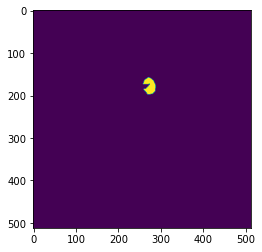

In [83]:
import matplotlib.pyplot as plt
plt.imshow(im[110])

In [60]:
outs[50].max()

tensor(1.)

In [73]:
im = sitk.ReadImage('/Users/joemarsilla/Downloads/HNSCC-3DCT-RT/HN_P001_1/structures/GTV.nrrd')

In [75]:
im = sitk.GetArrayFromImage(im)

In [32]:
path_+val+'.nrrd'

'/Users/joemarsilla/Downloads/HNSCC-3DCT-RT/1/structures/LIPS.nrrd'

In [61]:
len(oars)

307

In [63]:
data_ = {}
data_['OAR'] = oars
data_['OAR_PDDCA'] = pddca_oars
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd
# data_['Observer'] = ob

In [82]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_pddca.csv')
data_
data_['OAR'] = data_['OAR'].fillna("CHIASM")
data_.to_csv('/Users/joemarsilla/OARensemble2021_pddca.csv')

In [83]:
data_[data_['OAR'] == "CHIASM"]
# images of different sizes (sliding window must be different)
# exclude = ['0522c0727b', '0522c0727a']

,OAR,OAR_PDDCA,Patient,VolDice,95HD,SurfDice
1,CHIASM,Chiasm,0522c0002,0.387569,5.000000,1.639750
8,CHIASM,Chiasm,0522c0003,0.343921,4.472136,1.666032
15,CHIASM,Chiasm,0522c0009,0.367785,4.123106,1.548013
22,CHIASM,Chiasm,0522c0013,0.336088,7.017767,1.720296
29,CHIASM,Chiasm,0522c0014,0.334789,4.242641,1.408293
36,CHIASM,Chiasm,0522c0017,0.233449,6.480741,2.477979
43,CHIASM,Chiasm,0522c0057,0.370690,6.078624,1.380058
50,CHIASM,Chiasm,0522c0070,0.266247,7.719877,2.709699
57,CHIASM,Chiasm,0522c0077,0.440529,7.598990,0.770200
64,CHIASM,Chiasm,0522c0079,0.287356,8.261101,2.349879


In [79]:
data_

,OAR,OAR_PDDCA,Patient,VolDice,95HD,SurfDice
0,BSTEM,BrainStem,0522c0002,0.723295,4.582576,2.222664
1,NaN,Chiasm,0522c0002,0.387569,5.000000,1.639750
2,MAND,Mandible,0522c0002,0.835578,1.414214,0.771376
3,LOPTIC,OpticNerve_L,0522c0002,0.577428,1.970711,0.804067
4,ROPTIC,OpticNerve_R,0522c0002,0.536377,2.000000,0.856567
...,...,...,...,...,...,...
302,MAND,Mandible,0522c0878,0.858530,1.414214,0.640099
303,LOPTIC,OpticNerve_L,0522c0878,0.500000,3.707631,0.869060
304,ROPTIC,OpticNerve_R,0522c0878,0.366548,2.236068,1.184424
305,LPAR,Parotid_L,0522c0878,0.854056,2.828427,0.804400


In [66]:
# fdata = data_[~data_.Patient.isin(exclude)]
# exclude = ['Spinal-Canal']
# fdata = fdata[~fdata.OAR_Deepmind.isin(exclude)]

In [67]:
# fdata

In [69]:
import matplotlib.pyplot as plt
import seaborn as sea

Text(0, 0.5, '3D Volumetric Dice\n')

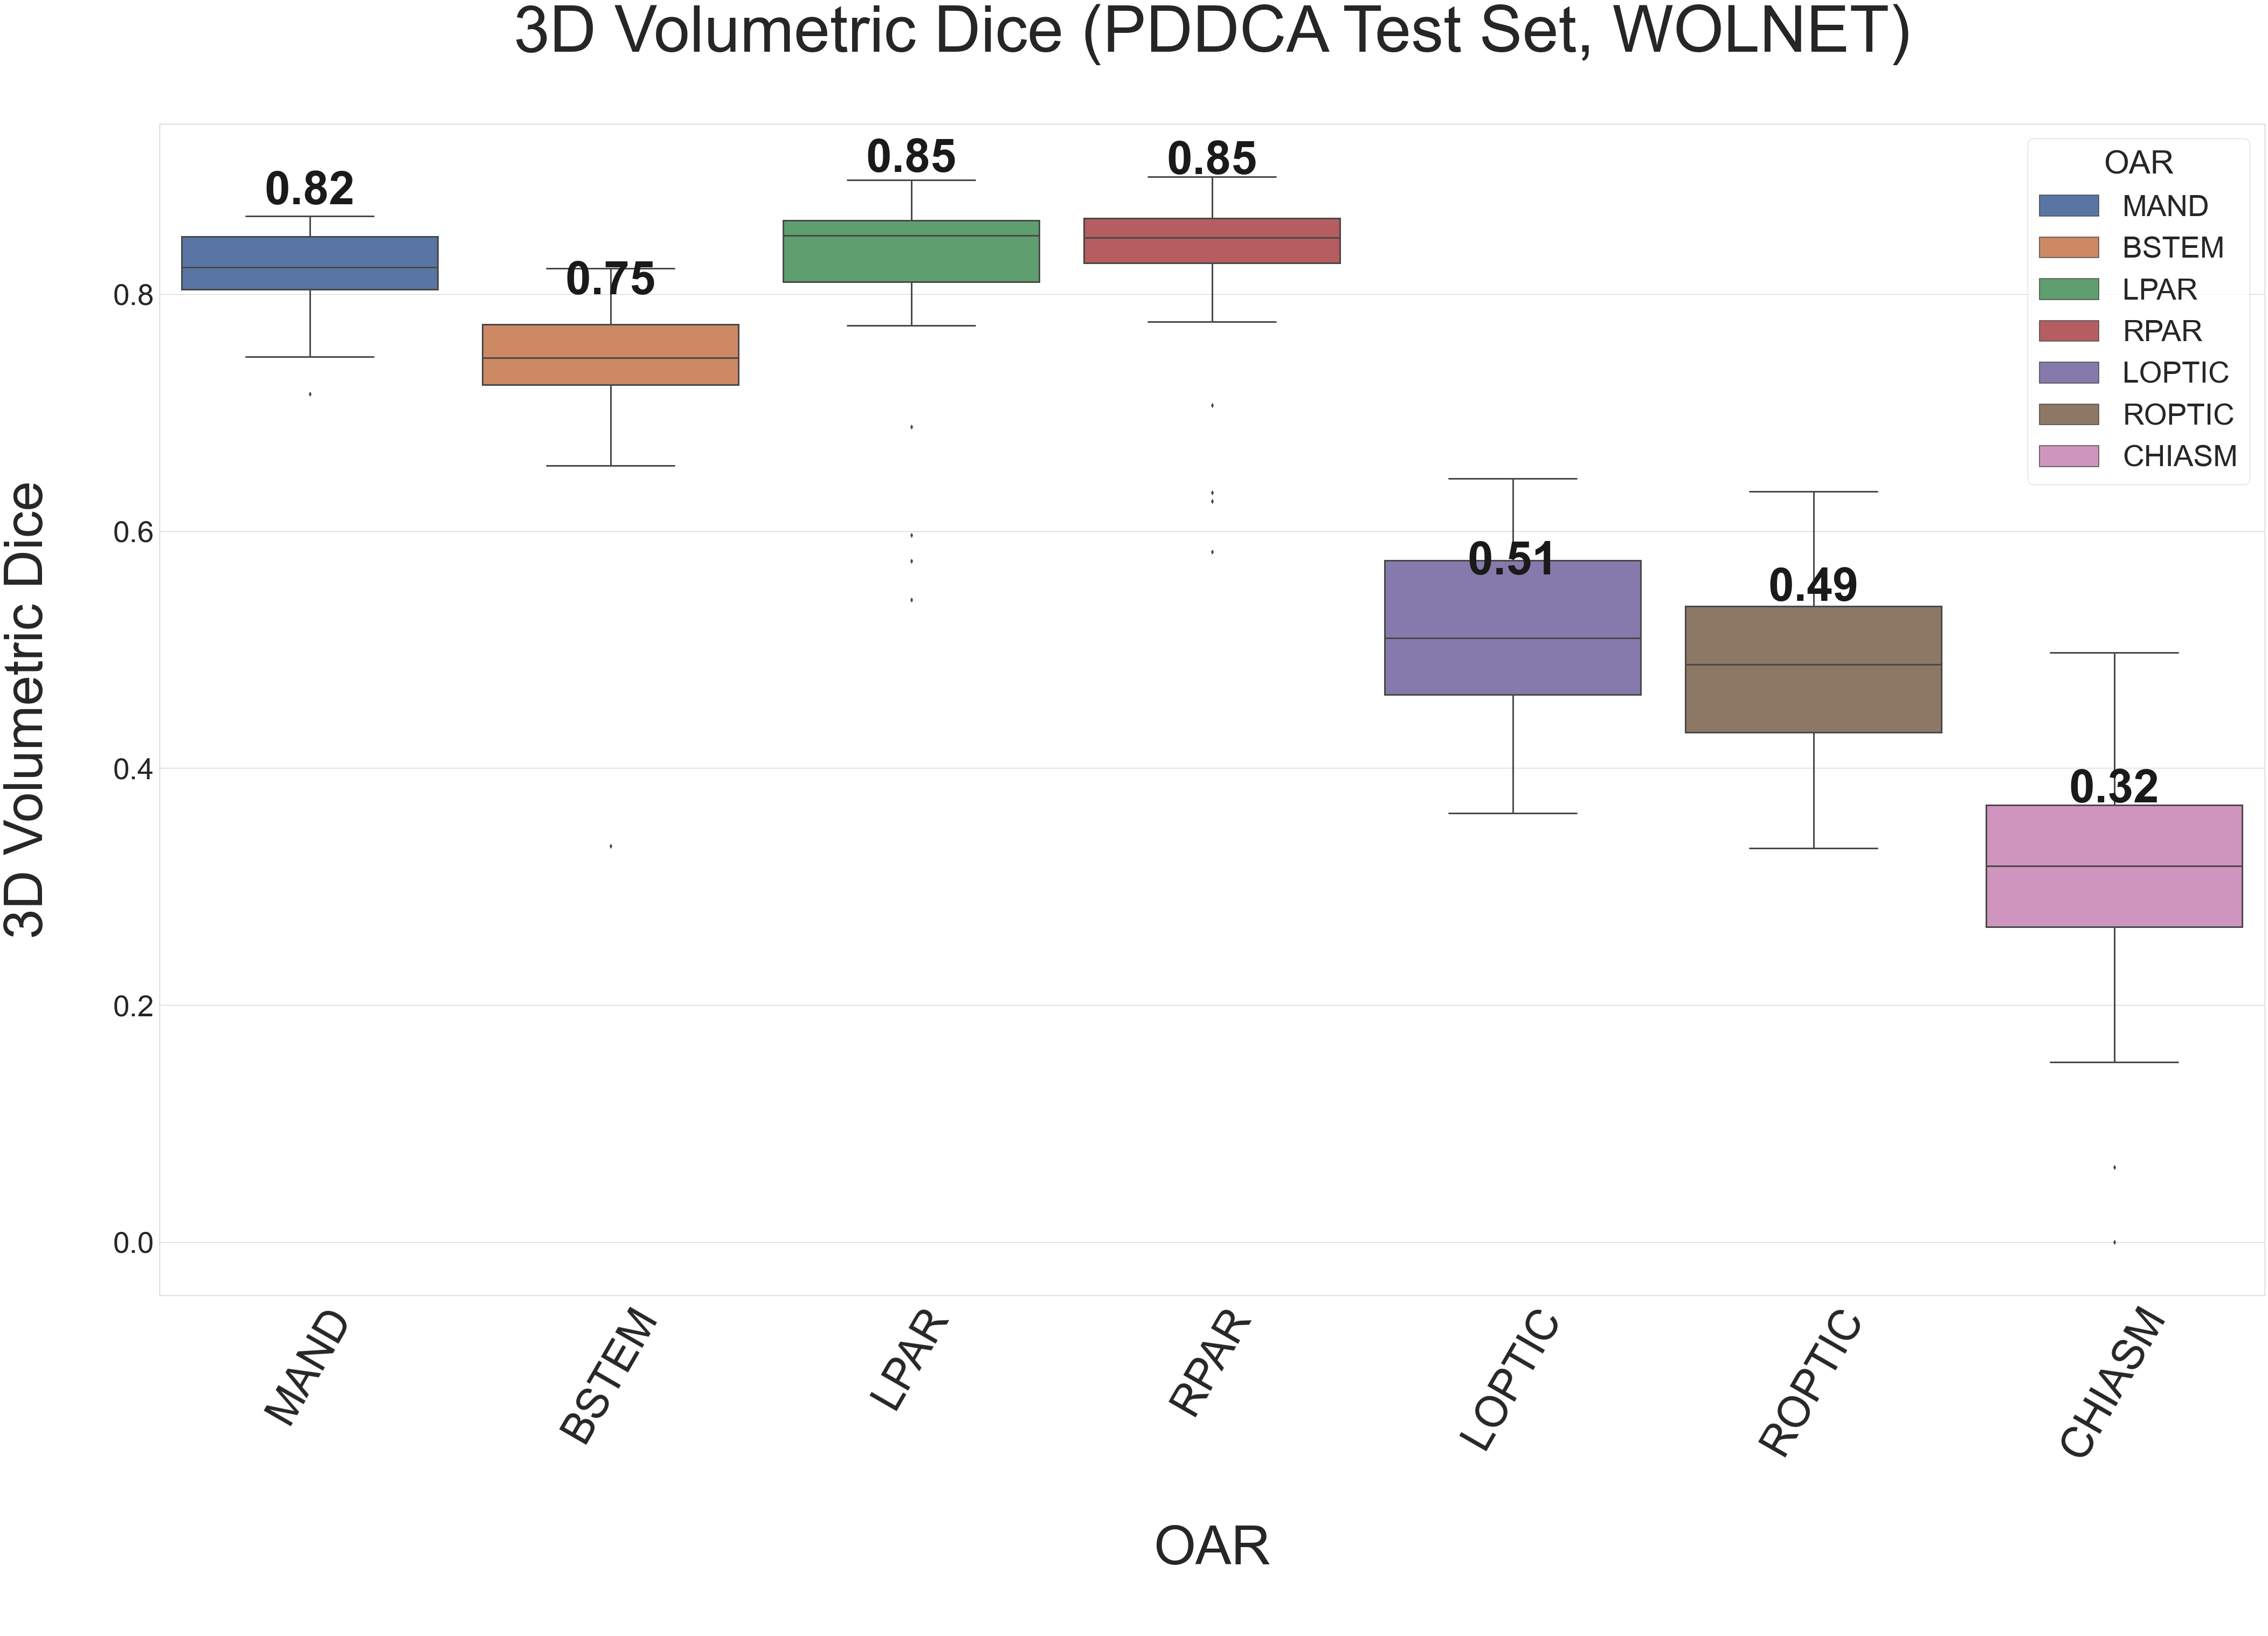

In [86]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
plt.title('3D Volumetric Dice (PDDCA Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'BSTEM', 'LPAR', 'RPAR', 'LOPTIC', 'ROPTIC', 'CHIASM']
# rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data_.OAR = data_.OAR.astype("category")
data_.OAR.cat.set_categories(rois, inplace=True)
data_.sort_values(["OAR"])
medians = data_.groupby(['OAR'])['VolDice'].median()
vertical_offset = data_['VolDice'].median() * 0.075 # offset from median for display
ax = sea.boxplot(data=data_, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.85, linewidth=3,  dodge=False) # hue_order=chosen,
ax.set_xticklabels(rois, rotation=60, fontsize=80)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
# ax.legend_.remove()

Text(0, 0.5, '95%HD\n')

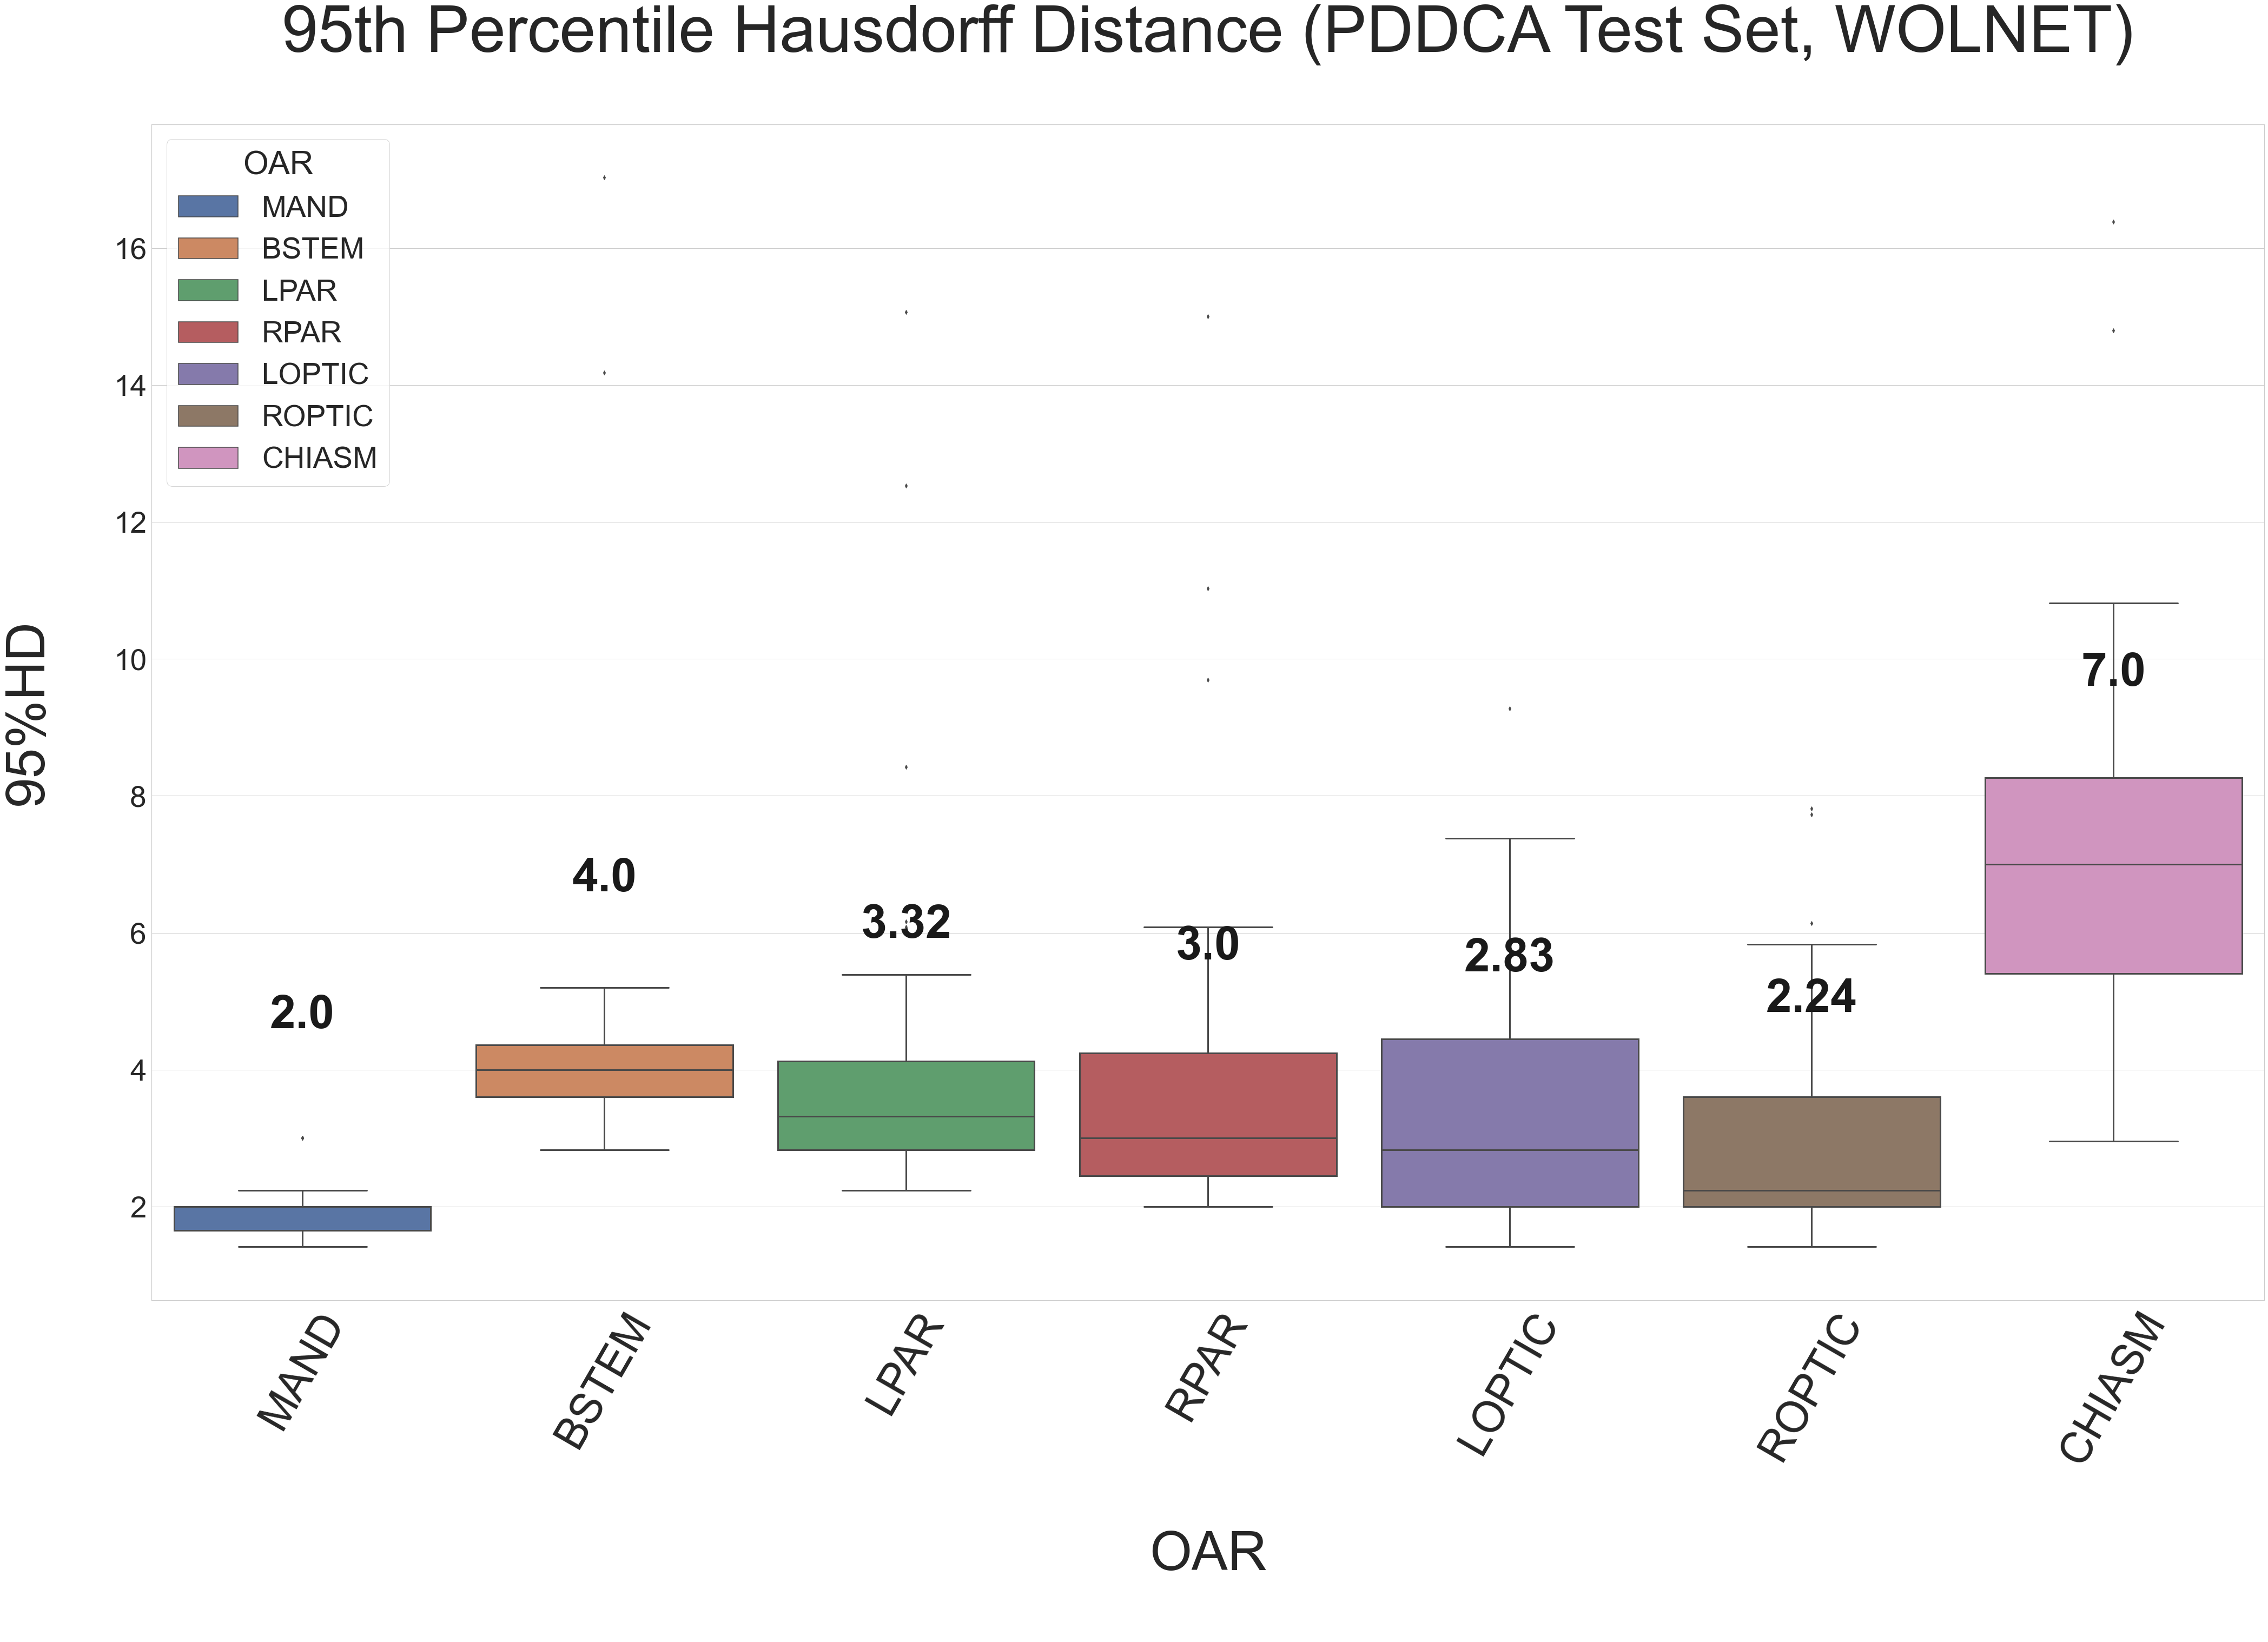

In [89]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (PDDCA Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data_[data_["95HD"]<17.5], x="OAR", y="95HD", hue="OAR",hue_order=rois, width=.85, linewidth=3, dodge=False)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
medians = data_.groupby(['OAR'])['95HD'].median()
vertical_offset = data_['95HD'].median() * .8 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
# ax.legend_.remove()

In [100]:
# testing files..
outs = np.load('/Users/joemarsilla/Downloads/hnscc_ai_preds/outs_53_FULL.npy')

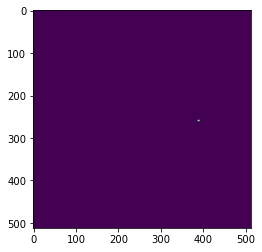

0


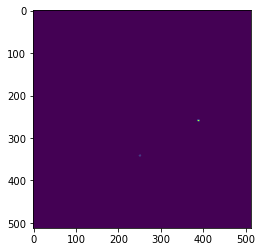

1


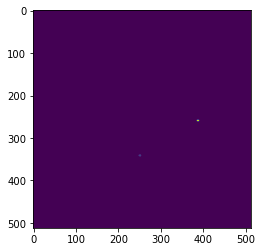

2


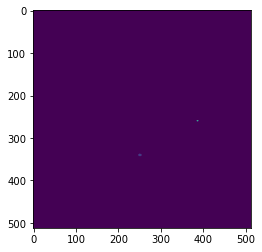

3


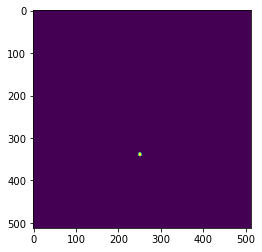

4


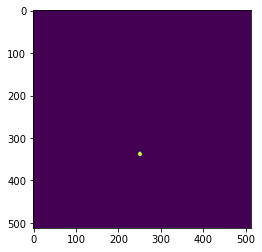

5


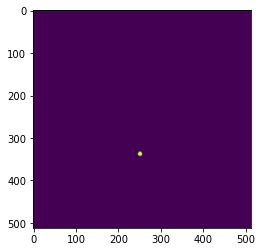

6


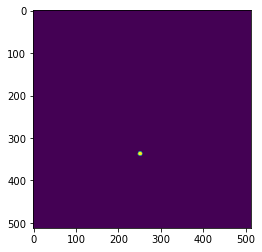

7


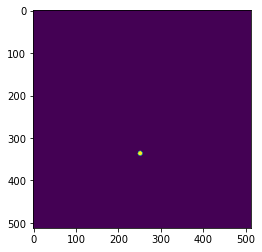

8


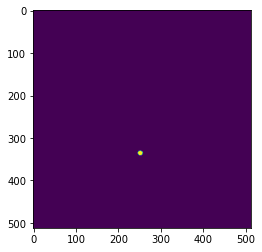

9


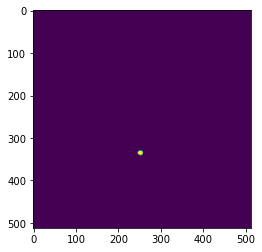

10


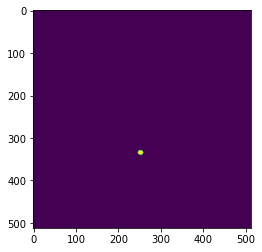

11


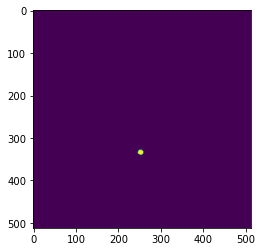

12


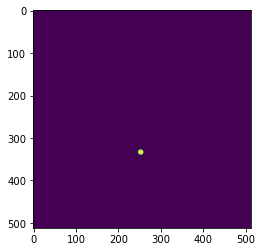

13


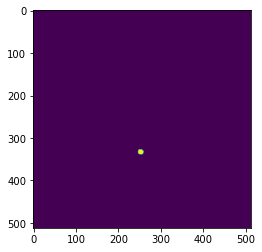

14


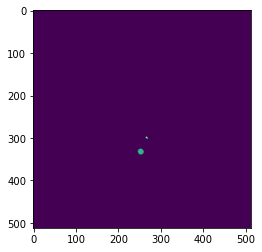

15


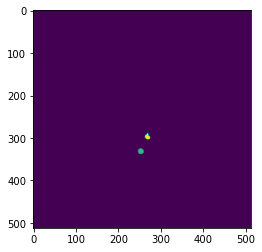

16


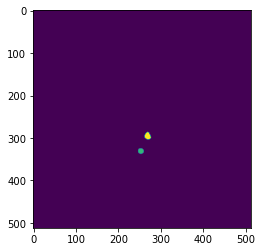

17


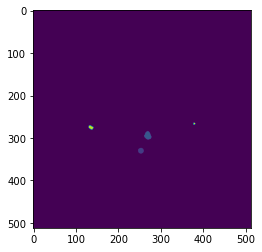

18


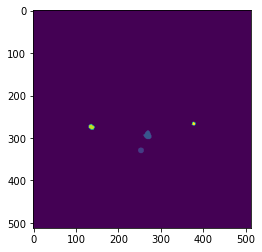

19


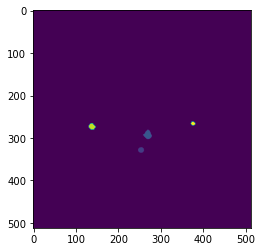

20


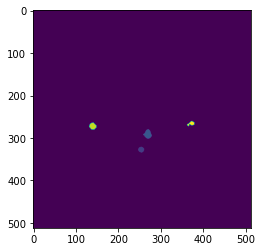

21


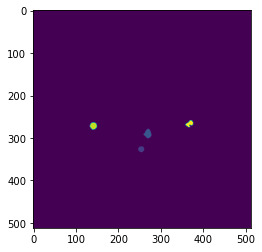

22


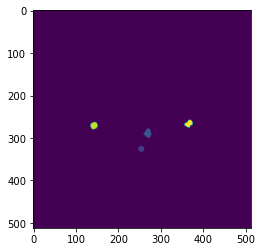

23


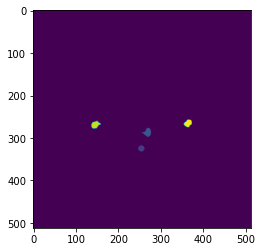

24


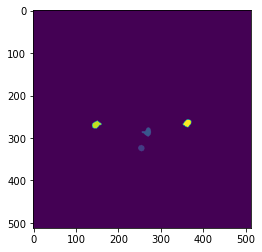

25


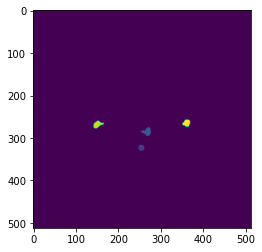

26


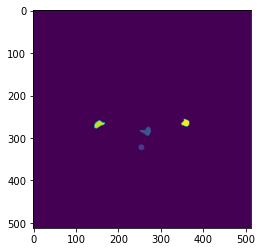

27


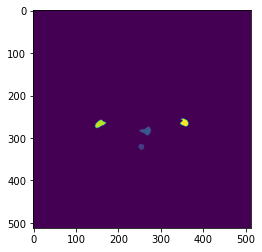

28


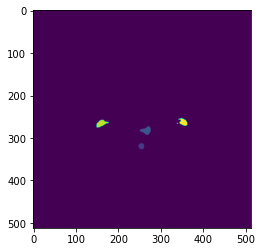

29


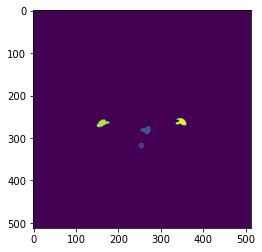

30


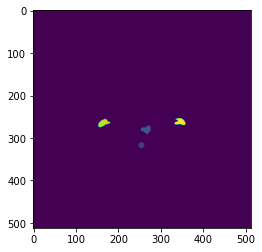

31


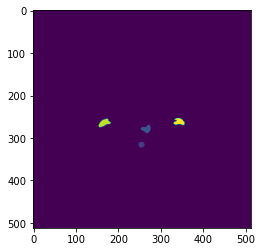

32


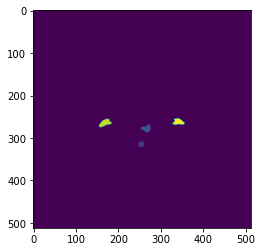

33


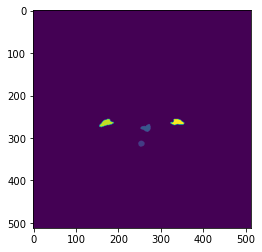

34


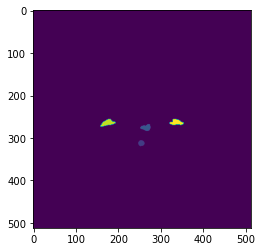

35


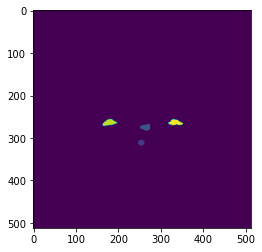

36


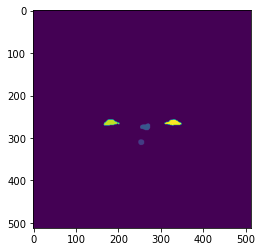

37


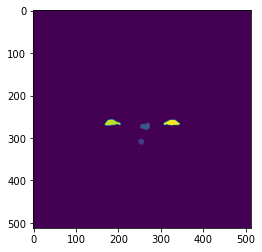

38


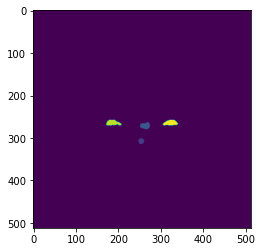

39


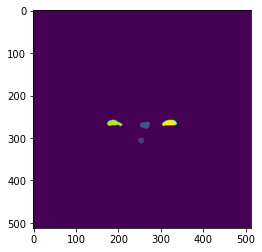

40


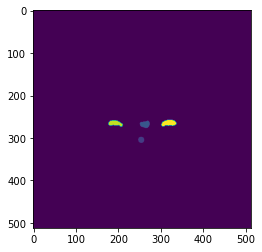

41


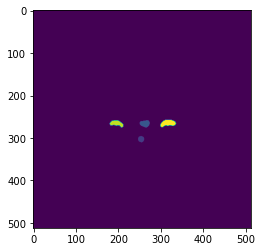

42


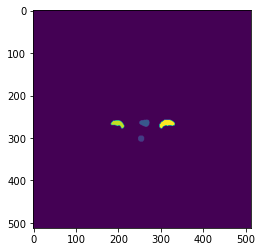

43


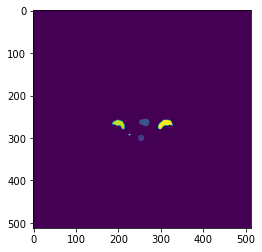

44


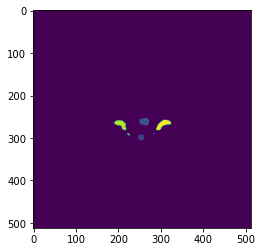

45


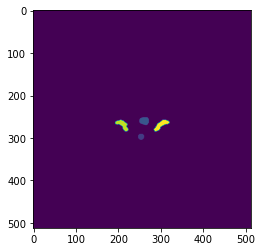

46


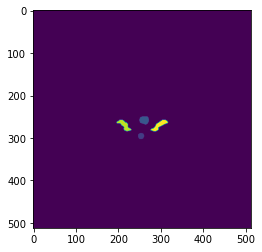

47


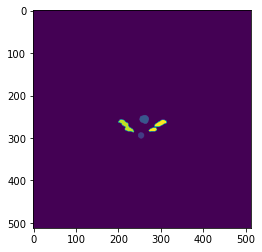

48


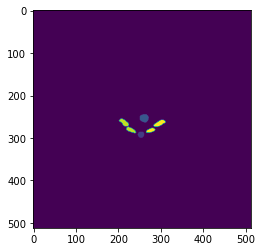

49


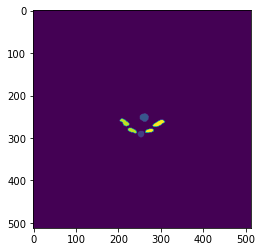

50


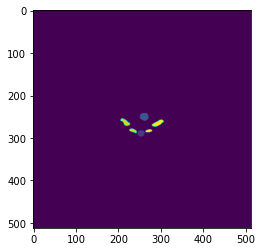

51


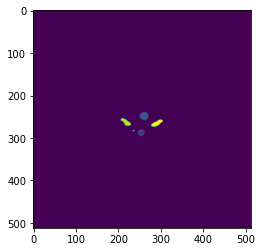

52


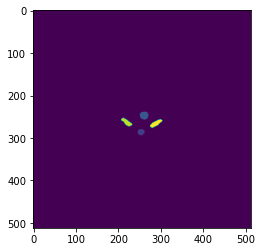

53


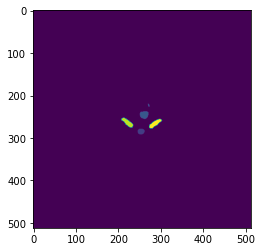

54


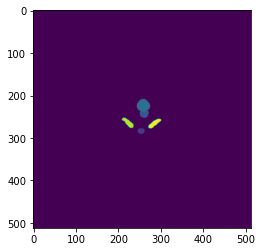

55


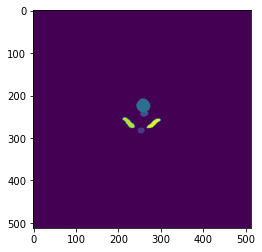

56


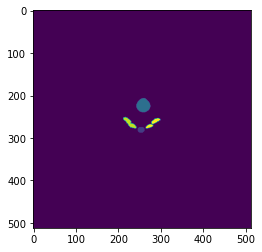

57


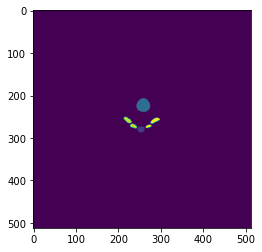

58


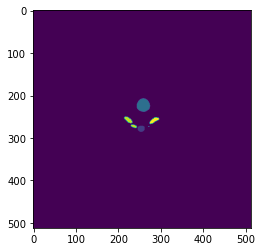

59


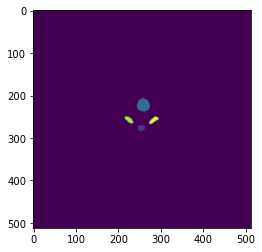

60


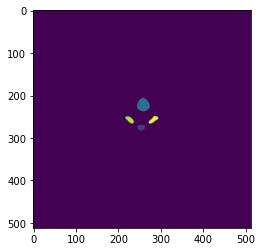

61


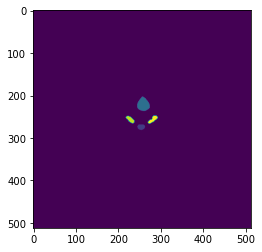

62


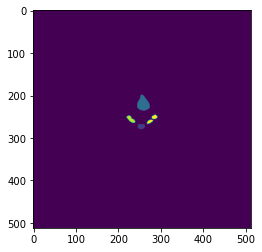

63


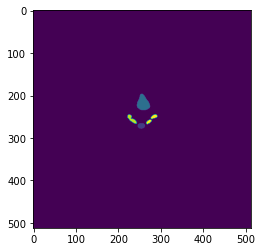

64


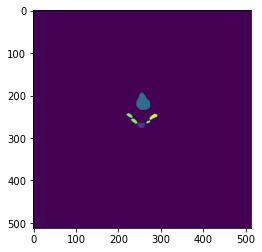

65


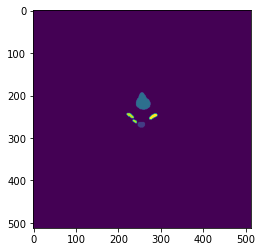

66


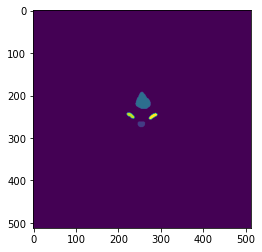

67


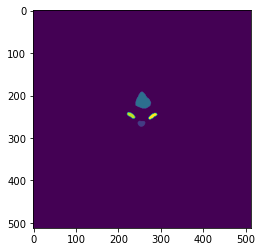

68


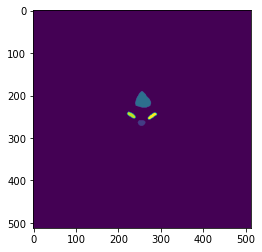

69


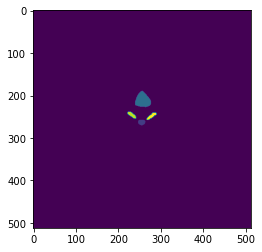

70


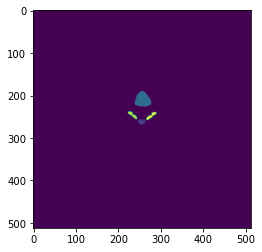

71


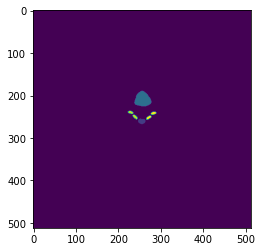

72


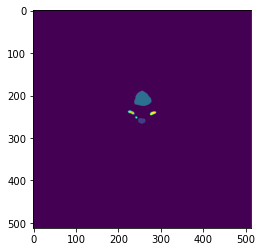

73


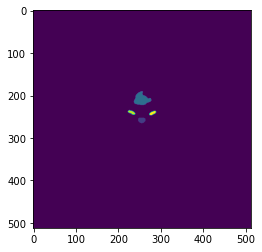

74


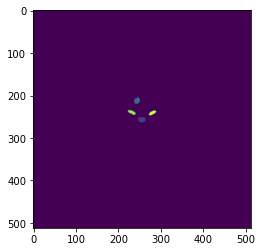

75


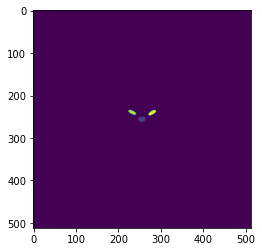

76


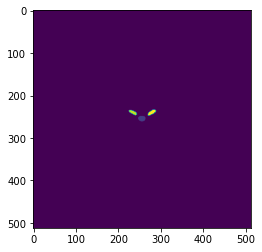

77


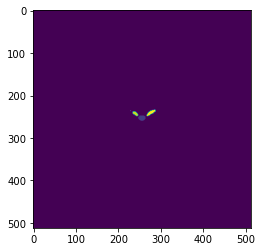

78


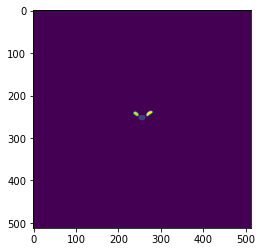

79


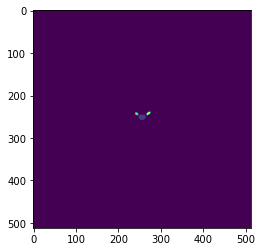

80


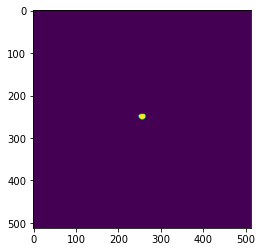

81


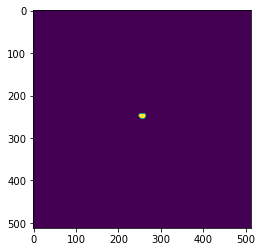

82


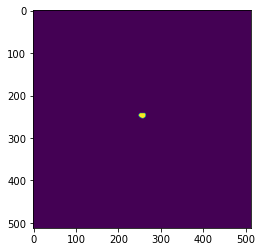

83


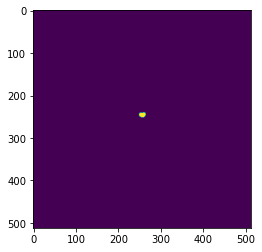

84


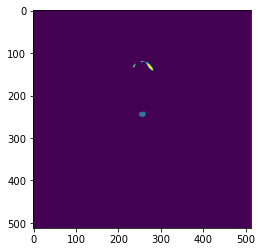

85


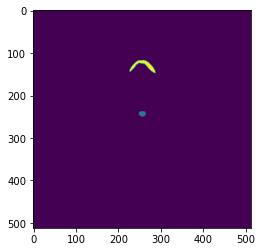

86


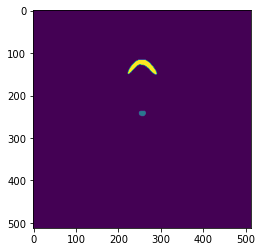

87


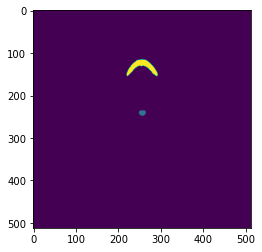

88


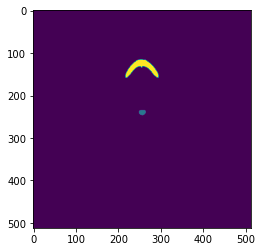

89


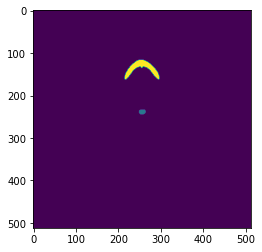

90


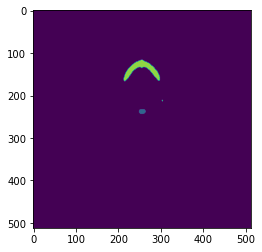

91


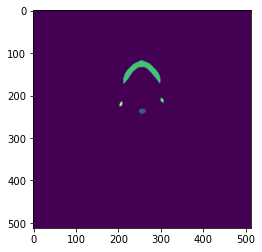

92


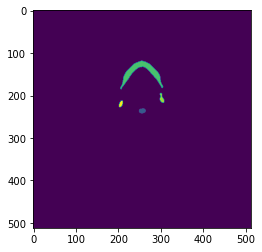

93


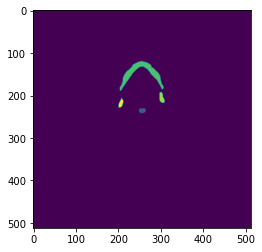

94


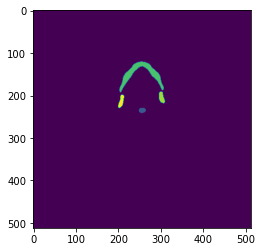

95


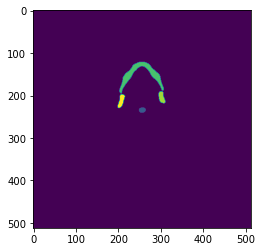

96


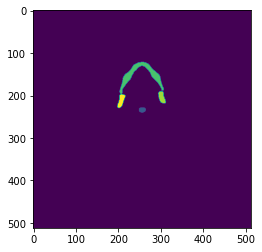

97


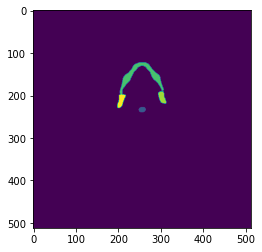

98


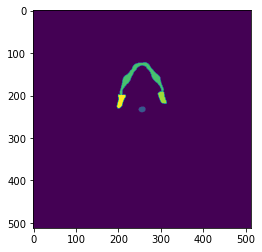

99


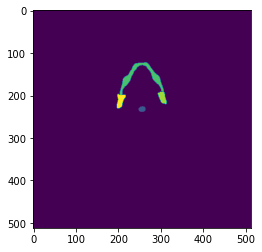

100


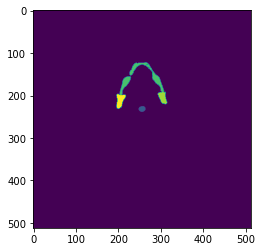

101


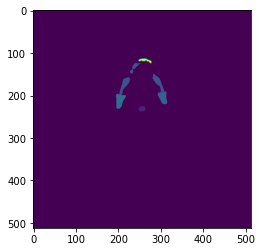

102


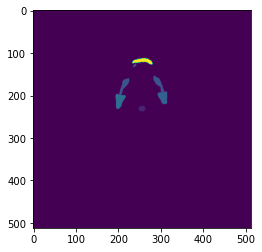

103


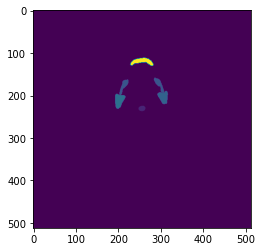

104


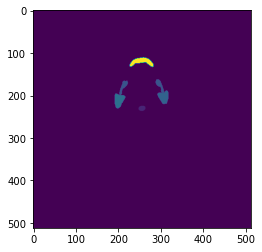

105


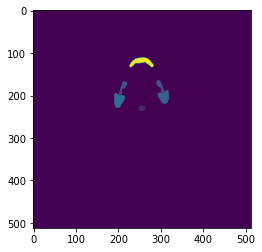

106


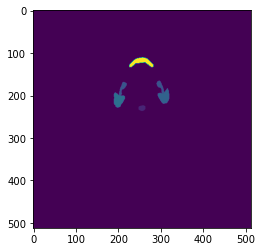

107


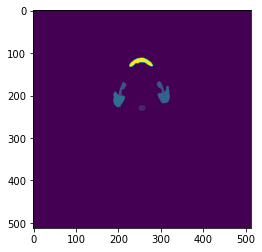

108


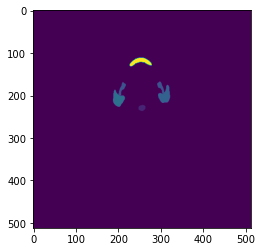

109


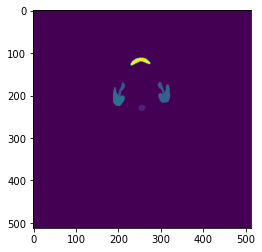

110


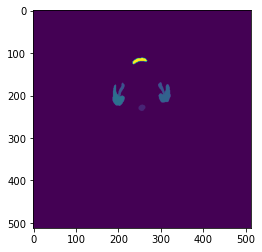

111


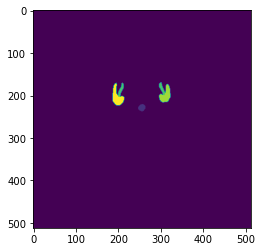

112


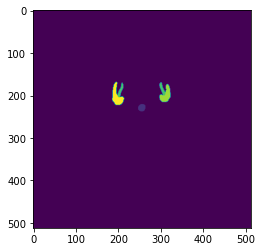

113


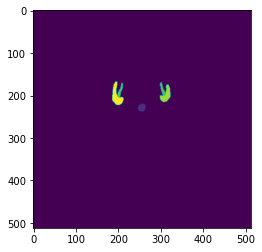

114


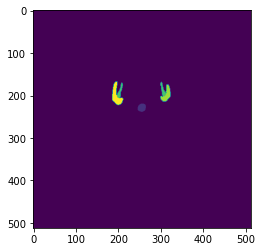

115


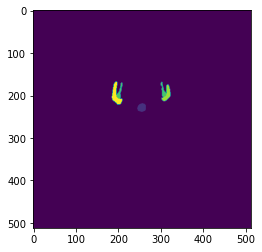

116


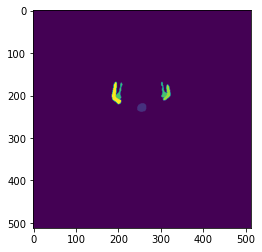

117


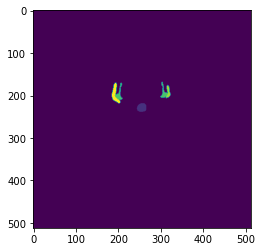

118


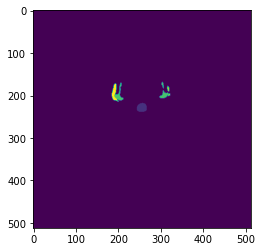

119


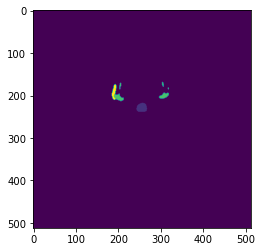

120


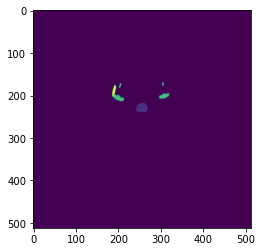

121


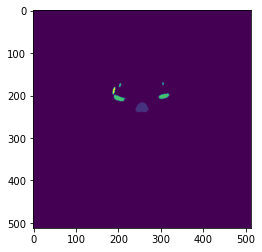

122


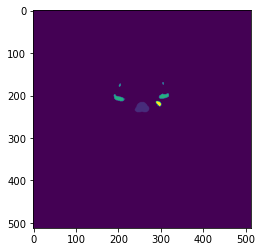

123


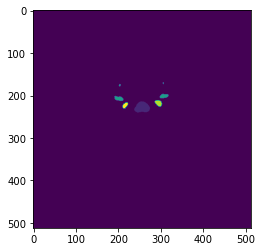

124


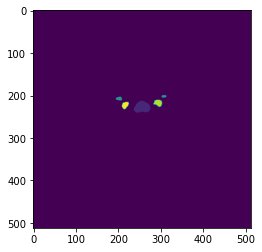

125


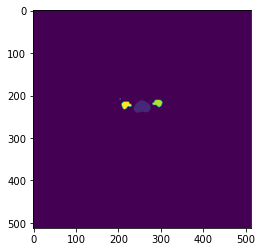

126


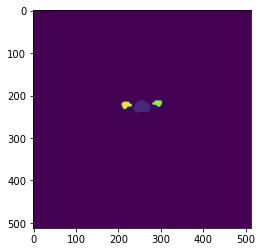

127


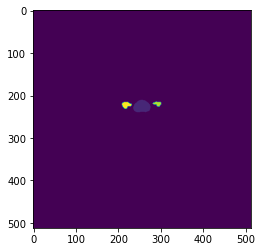

128


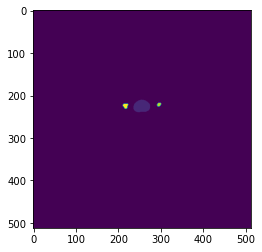

129


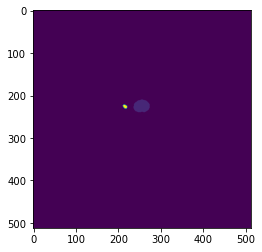

130


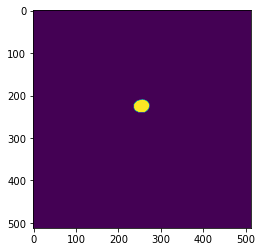

131


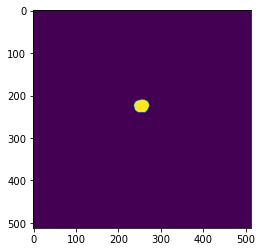

132


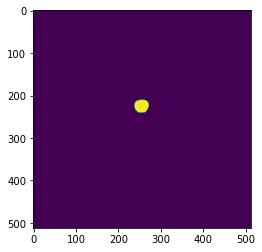

133


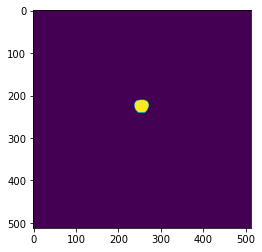

134


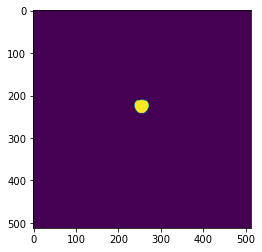

135


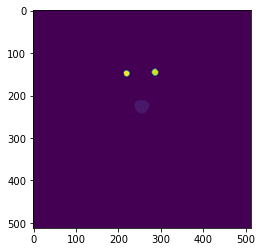

136


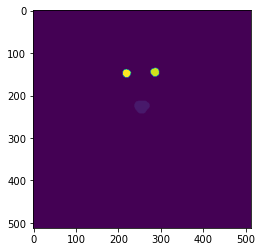

137


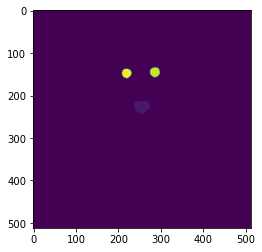

138


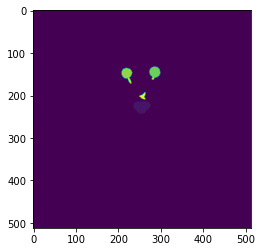

139


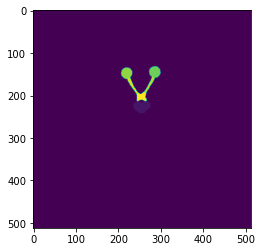

140


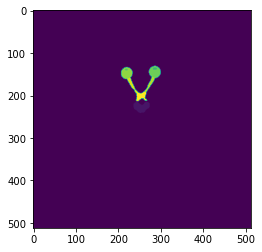

141


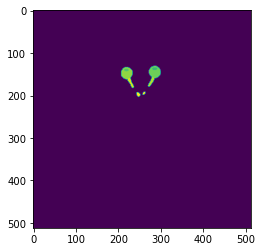

142


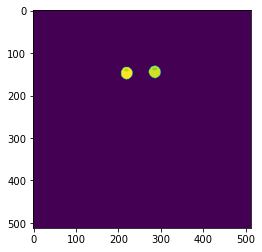

143


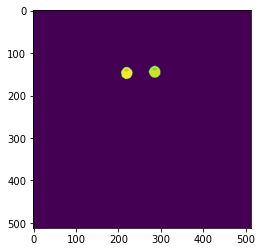

144


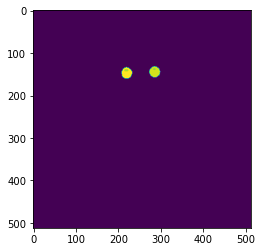

145


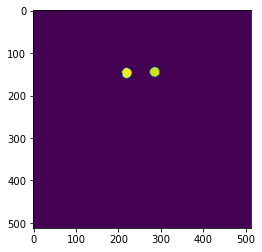

146


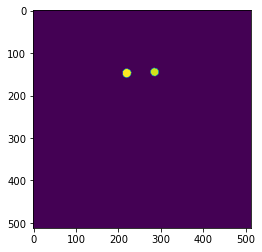

147


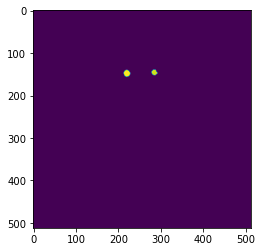

148


In [103]:
for i, slice_ in enumerate(outs):
    if slice_.max() > 0:
        plt.imshow(slice_)
        plt.show()
        print(i)